In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.linear_model import LinearRegression

In [2]:
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, ReLU, ELU, PReLU, Input, Concatenate, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import mse, binary_crossentropy
import tensorflow as tf

In [3]:
def myloss2d(y_true, y_pred, alpha = 100):
    #alpha determines the amount of decorrelation; 0 means no decorrelation.
    
    #We want to learn f(g(x)) = x with g != identity and g(x) and x should have the same probability density.
    #g(x) = y_pred[:,0]
    #f(g(x)) = y_pred[:,1]
    #h(x) = y_pred[:,2]
    #h(g(x)) = y_pred[:,3]
    
    myoutput =  mse(y_true[:,0],y_pred[:,1]) \
                - alpha*binary_crossentropy(y_pred[:,2],K.ones_like(y_pred[:,2])) \
                - alpha*binary_crossentropy(y_pred[:,3],0.*K.ones_like(y_pred[:,2]))
    return myoutput

In [4]:
num_iters = 10
training = 20
zero = [0]*100000
slopes = []
intercepts = []

for j in range(num_iters):
    print("on j=",j)
    x0 = np.random.normal(0,1,100000)
    x1 = np.random.normal(0,2,100000)
    X = np.concatenate((np.c_[x0, zero], np.c_[zero, x1]))
    np.random.shuffle(X)
    
    myinput_2d = Input(shape=(2,))
    encoded_2d = Dense(5, activation='elu')(myinput_2d)
    encoded_2d = Dense(5, activation='elu')(encoded_2d)
    encoded_2d = Dense(2, activation='linear')(encoded_2d)

    encoder_2d = Model(myinput_2d, encoded_2d)
    encoder2_2d = encoder_2d(encoder_2d(myinput_2d))
    autoencoder_2d = Model(myinput_2d, encoder2_2d)

    combinedModel_2d = Model(myinput_2d,Concatenate(axis=-1)([encoded_2d, encoder2_2d]))

    myinput_classify_2d = Input(shape=(2,))
    myclassifier_2d = Dense(128, activation='elu')(myinput_classify_2d)
    myclassifier_2d = Dense(64, activation='elu')(myclassifier_2d)
    myclassifier_2d = Dense(1, activation='sigmoid')(myclassifier_2d)
    myclassifier_model_2d = Model(myinput_classify_2d, myclassifier_2d)
    myclassifier_input_2d = myclassifier_model_2d(myinput_2d)
    myclassifier_encoded_2d = myclassifier_model_2d(encoded_2d)

    combinedModel_classifier_2d = Model(myinput_2d,Concatenate(axis=-1)([encoded_2d, encoder2_2d, myclassifier_input_2d, myclassifier_encoded_2d]))

    preds = []
    preds += [encoder_2d.predict(X)]

    for i in range(training):
        #Now, train the classifier
        encoded_x_2d = encoder_2d.predict(X)
        myclassifier_model_2d.compile(optimizer='adam', loss='binary_crossentropy')
        myclassifier_model_2d.fit(np.concatenate([X,encoded_x_2d]),np.concatenate([np.ones(len(X)),np.zeros(len(X))]), epochs=1, batch_size=int(0.01*len(X)), verbose=0)

        #Now, update the autoencoder
        for layer in myclassifier_model_2d.layers[:]:
            layer.trainable = False

        combinedModel_classifier_2d.compile(optimizer='adam', loss=lambda y_true, y_pred: myloss2d(y_true, y_pred))
        combinedModel_classifier_2d.fit(X,X, epochs=1, batch_size=int(0.01*len(X)), verbose=0)

        autoencoder_2d.compile(optimizer='adam', loss='mse')
        autoencoder_2d.fit(X,X, epochs=5, batch_size=int(0.01*len(x0)), verbose=0)

        preds += [encoder_2d.predict(X)]

        for layer in myclassifier_model_2d.layers[:]:
            layer.trainable = True
            
            
            
    model = LinearRegression().fit(X, preds[-1]);
    slopes.append(model.coef_);
    intercepts.append(model.intercept_)
    

on j= 0
on j= 1
on j= 2
on j= 3
on j= 4
on j= 5
on j= 6
on j= 7
on j= 8
on j= 9


In [5]:
print("Determinants:")
for i in range(num_iters):
    det = np.linalg.det(slopes[i])
    print(round(det, 0))

Determinants:
-1.0
-2.0
-1.0
-5.0
1.0
0.0
-1.0
-1.0
-1.0
1.0


In [6]:
print("Slopes:")
for i in range(num_iters):
    s = [[str(np.around(e, 2)) for e in row] for row in slopes[i]]
    lens = [max(map(len, col)) for col in zip(*s)]
    fmt = '\t'.join('{{:{}}}'.format(x) for x in lens)
    table = [fmt.format(*row) for row in s]
    print ("\n".join(table))
    print("\n")

Slopes:
-7.54	-13.83
3.66 	6.82  


-6.24 	3.45
-12.51	7.22


-6.13	-5.32
7.15 	6.31 


-5.98	-3.44
13.78	8.71 


0.7  	0.16
-1.25	0.83


-3.76	-4.2
3.22 	3.59


3.59 	1.62 
-4.19	-2.26


-0.39	-0.09
-2.79	1.48 


1.55 	-0.23
-4.07	-0.18


0.98 	-0.01
-0.01	0.99 




In [7]:
print("Intercepts:")
for i in range(num_iters):
    print(np.around(intercepts[i], 2))

Intercepts:
[-19.97   8.4 ]
[ 6.14 11.45]
[-5.97  5.75]
[-6.51 11.42]
[0.29 0.91]
[-4.26  2.86]
[-3.62  5.98]
[2.55 4.74]
[-0.49  2.12]
[-0. -0.]


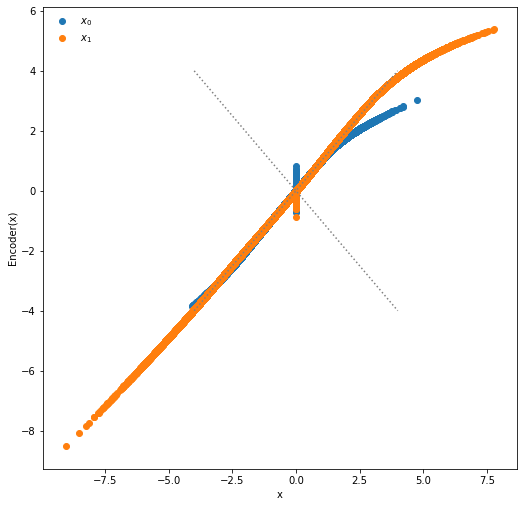

In [8]:
f = plt.figure(figsize=(8.5, 8.5))
plt.scatter(X[:,0],preds[-1][:,0],label="$x_0$")
plt.scatter(X[:,1],preds[-1][:,1],label="$x_1$")
plt.plot(np.linspace(-4,4,10),np.linspace(-4,4,10),ls=':',color="gray")
plt.plot(np.linspace(-4,4,10),-np.linspace(-4,4,10),ls=':',color="gray")
plt.xlabel("x")
plt.ylabel("Encoder(x)")
plt.legend(frameon=False)

In [9]:
mypreds = combinedModel_classifier_2d.predict(X)

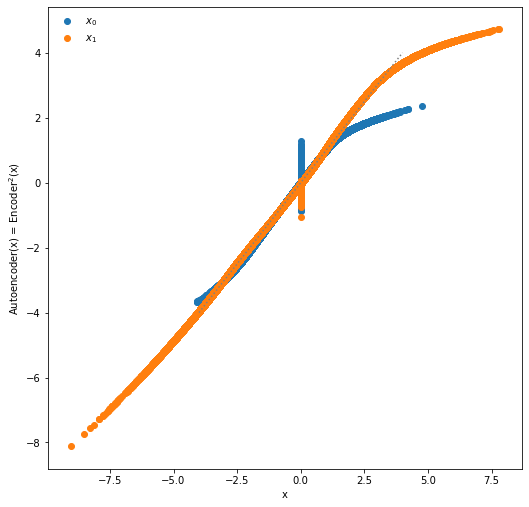

In [10]:
f = plt.figure(figsize=(8.5, 8.5))
plt.scatter(X[:,0],mypreds[:,2],label="$x_0$")
plt.scatter(X[:,1],mypreds[:,3],label="$x_1$")
plt.plot(np.linspace(-4,4,10),np.linspace(-4,4,10),ls=':',color="gray")
plt.xlabel("x")
plt.ylabel("Autoencoder(x) = Encoder$^2$(x)")
plt.legend(frameon=False)

In [11]:
Y = encoder_2d.predict(X)

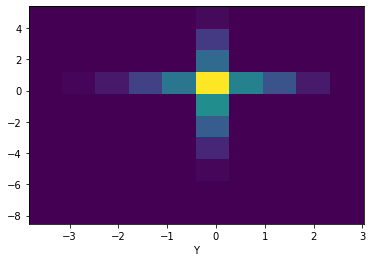

In [12]:
plt.hist2d(Y[:,0], Y[:, 1]);
plt.xlabel("Y");

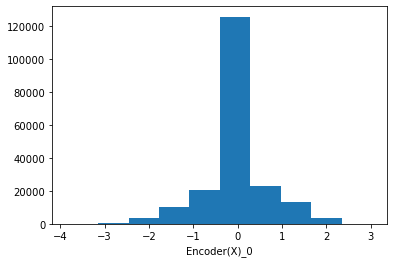

In [13]:
plt.hist(Y[:,0], bins=10);
plt.xlabel("Encoder(X)_0");

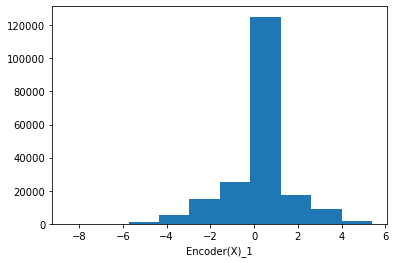

In [14]:
plt.hist(Y[:,1], bins=10);
plt.xlabel("Encoder(X)_1");